In [26]:
!pip install matplotlib
!pip install networkx
!pip install pandas

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [27]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
with open('./dati-json/dpc-covid19-ita-province.json') as f:
    covid19_provinces_data = json.load(f)

with open('./dati-json/dpc-covid19-ita-regioni.json') as f:
    covid19_regions_data = json.load(f)

In [29]:
data = []
for province in covid19_provinces_data:
    province_denomination = province['sigla_provincia']
    province_date = province['data']
    # Es. ('FI', '2020-02-24T...', all data on that row)
    # the first 2 values will be used as key
    data.append([province_denomination, province_date, province.values()]) 

# Sort according to the date
data = sorted(data, key=lambda x: x[0])
# Prepare data for the DataFrame
index = []
province_info = []
for province in data:
    index.append([province[0], province[1]]) # (Name, date)
    province_info.append(province[2]) # (codice_regione, codice_provincia, ...)
index = pd.MultiIndex.from_tuples(index) # Index ranking: 1° City's name, 2° date
# Create finally the DataFrame
dati = pd.DataFrame(province_info, index=index, columns=covid19_provinces_data[0].keys())
# and drop some usless columns
dati = dati.drop(columns=['codice_regione', 'denominazione_provincia', 'stato', 'codice_provincia', 'note_it', 'note_en'])
dati

data  denominazione_regione  \
   2020-02-24T18:00:00  2020-02-24T18:00:00                Abruzzo   
   2020-02-24T18:00:00  2020-02-24T18:00:00             Basilicata   
   2020-02-24T18:00:00  2020-02-24T18:00:00           P.A. Bolzano   
   2020-02-24T18:00:00  2020-02-24T18:00:00               Calabria   
   2020-02-24T18:00:00  2020-02-24T18:00:00               Campania   
   2020-02-24T18:00:00  2020-02-24T18:00:00         Emilia-Romagna   
   2020-02-24T18:00:00  2020-02-24T18:00:00  Friuli Venezia Giulia   
   2020-02-24T18:00:00  2020-02-24T18:00:00                  Lazio   
   2020-02-24T18:00:00  2020-02-24T18:00:00                Liguria   
   2020-02-24T18:00:00  2020-02-24T18:00:00              Lombardia   
   2020-02-24T18:00:00  2020-02-24T18:00:00                 Marche   
   2020-02-24T18:00:00  2020-02-24T18:00:00                 Molise   
   2020-02-24T18:00:00  2020-02-24T18:00:00               Piemonte   
   2020-02-24T18:00:00  2020-02-24T18:00:00                 Puglia   
   2020-02-24T18:00:00  2020-02-24T18:00:00               Sardegna   
   2020-02-24T18:00:00  2020-02-24T18:00:00                Sicilia   
   2020-02-24T18:00:00  2020-02-24T18:00:00                Toscana   
   2020-02-24T18:00:00  2020-02-24T18:00:00            P.A. Trento   
   2020-02-24T18:00:00  2020-02-24T18:00:00                 Umbria   
   2020-02-24T18:00:00  2020-02-24T18:00:00          Valle d'Aosta   
   2020-02-24T18:00:00  2020-02-24T18:00:00                 Veneto   
   2020-02-25T18:00:00  2020-02-25T18:00:00                Abruzzo   
   2020-02-25T18:00:00  2020-02-25T18:00:00             Basilicata   
   2020-02-25T18:00:00  2020-02-25T18:00:00           P.A. Bolzano   
   2020-02-25T18:00:00  2020-02-25T18:00:00               Calabria   
   2020-02-25T18:00:00  2020-02-25T18:00:00               Campania   
   2020-02-25T18:00:00  2020-02-25T18:00:00         Emilia-Romagna   
   2020-02-25T18:00:00  2020-02-25T18:00:00  Friuli Venezia Giulia   
   2020-02-25T18:00:00  2020-02-25T18:00:00                  Lazio   
   2020-02-25T18:00:00  2020-02-25T18:00:00                Liguria   
...                                     ...                    ...   
VV 2020-04-20T17:00:00  2020-04-20T17:00:00               Calabria   
   2020-04-21T17:00:00  2020-04-21T17:00:00               Calabria   
   2020-04-22T17:00:00  2020-04-22T17:00:00               Calabria   
   2020-04-23T17:00:00  2020-04-23T17:00:00               Calabria   
   2020-04-24T17:00:00  2020-04-24T17:00:00               Calabria   
   2020-04-25T17:00:00  2020-04-25T17:00:00               Calabria   
   2020-04-26T17:00:00  2020-04-26T17:00:00               Calabria   
   2020-04-27T17:00:00  2020-04-27T17:00:00               Calabria   
   2020-04-28T17:00:00  2020-04-28T17:00:00               Calabria   
   2020-04-29T17:00:00  2020-04-29T17:00:00               Calabria   
   2020-04-30T17:00:00  2020-04-30T17:00:00               Calabria   
   2020-05-01T17:00:00  2020-05-01T17:00:00               Calabria   
   2020-05-02T17:00:00  2020-05-02T17:00:00               Calabria   
   2020-05-03T17:00:00  2020-05-03T17:00:00               Calabria   
   2020-05-04T17:00:00  2020-05-04T17:00:00               Calabria   
   2020-05-05T17:00:00  2020-05-05T17:00:00               Calabria   
   2020-05-06T17:00:00  2020-05-06T17:00:00               Calabria   
   2020-05-07T17:00:00  2020-05-07T17:00:00               Calabria   
   2020-05-08T17:00:00  2020-05-08T17:00:00               Calabria   
   2020-05-09T17:00:00  2020-05-09T17:00:00               Calabria   
   2020-05-10T17:00:00  2020-05-10T17:00:00               Calabria   
   2020-05-11T17:00:00  2020-05-11T17:00:00               Calabria   
   2020-05-12T17:00:00  2020-05-12T17:00:00               Calabria   
   2020-05-13T17:00:00  2020-05-13T17:00:00               Calabria   
   2020-05-14T17:00:00  2020-05-14T17:00:00               Calabria   
   2020-05-15T17:00:00  2020-05-15T17:00:00      

Text(0.5, 1.0, 'Top 15 provinces with most cases')

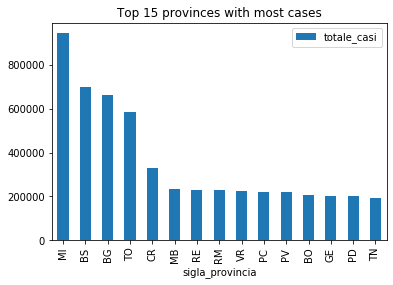

In [30]:
# group by "sigla_provincia" and sum all the values. Then drop 'lat' and 'long' columns and show 
# the top 15 provinces with the highest value on 'totale_casi'
dati.groupby(['sigla_provincia']).sum().drop(columns=['lat', 'long']).nlargest(15, 'totale_casi').plot(kind="bar")
plt.title("Top 15 provinces with most cases") # I don't know why this 'plt.title()' is working 
#but the others right below don't

In [31]:
# Get the provinces name (Sigle)
provinces = dati.sigla_provincia.unique()
# Create a DataFrame with total cases per month for each province
cases_per_month = {}

for province in provinces: 
    province_info = dati.loc[province]
    # The 'groupby(province_info.data.str[:7]' is used to group the rows according to the month
    # The [:7] is used to slice the first t letters of the 'data' column
    # 2020-05-15T17:00:00 ---> 2020-05
    # And finally sum the 'totale_casi' values grouped by month for each province
    cases_per_month[province] = pd.Series(province_info.groupby(province_info.data.str[:7])['totale_casi'].sum())

# Create the DataFrame using the Series defined in the for loop
cpm = pd.DataFrame(cases_per_month)
cpm.index.name = "" # Works fine even without this line, but there was an empty line that was bothering me
cpm = cpm.T # For a better view
cpm

,2020-02,2020-03,2020-04,2020-05
,198,39032,86204,60379
AG,0,878,3697,2615
AL,0,14258,74646,70245
AN,0,12655,47962,34855
AO,0,6155,28725,21967
AP,0,1465,7714,5445
AQ,0,961,6467,4634
AR,0,3291,14922,12551
AT,0,4462,29074,31891
AV,0,2381,12028,9372


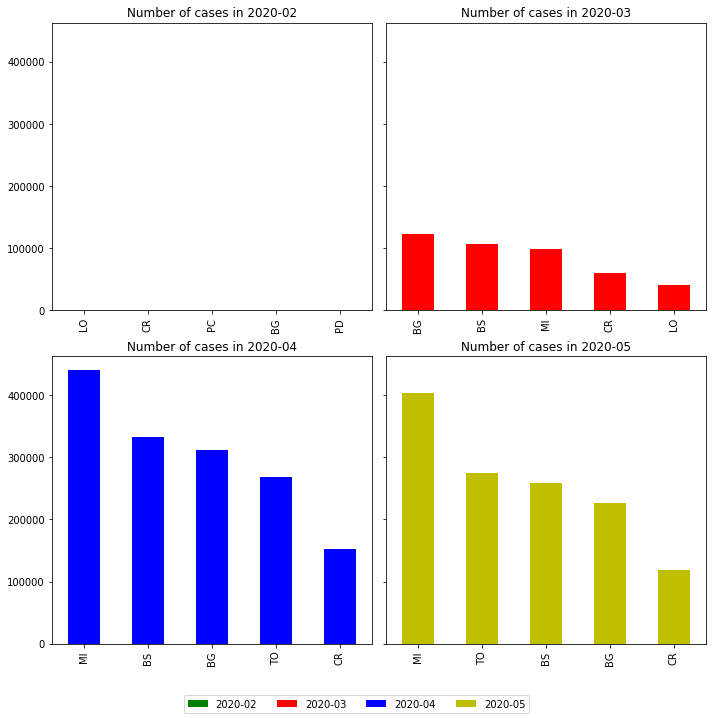

In [32]:
grid_size = (2,2) # For the 4 month considered
colors = ['g', 'r', 'b', 'y']
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], sharey=True, figsize=(10,10))
cities_with_worst_cases = [] # Store the name of the cities with the worst cases

month = 0
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        # Cities twith the worst cases in the current month
        worst_cases = cpm.nlargest(5, cpm.columns[month])[cpm.columns[month]]
        worst_cases.plot(ax=axes[i,j], kind='bar', legend=False, color=colors[month])
        axes[i, j].set_title('Number of cases in '+cpm.columns[month]) # Doesn't work
        cities_with_worst_cases.append(worst_cases)
        month += 1
        
fig.tight_layout()
fig.subplots_adjust(bottom=0.1)
fig.legend(labels=cpm.columns, loc="lower center", ncol=4)

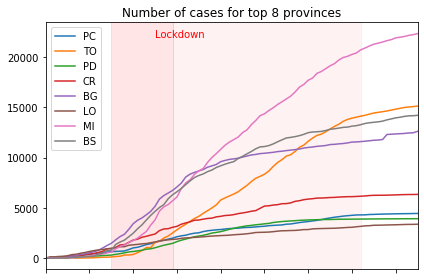

In [33]:
# Create a set of the cities with the worst case 
interested_city = list(set([item for sublist in [list(city.index) for city in cities_with_worst_cases] for item in sublist]))


# Collect information about these cities day by day
for i in range(len(interested_city)):
    dati.loc[interested_city[i]]['totale_casi'].plot(
        kind='line', 
        label=interested_city[i], 
        title="Number of cases for top 8 provinces").set_xticklabels([])
    #plt.plot(list(range(len(case_per_day))), case_per_day, label=interested_city[i], title="wooo")
    

plt.text(25, 22000, "Lockdown", color="r")
plt.axvspan(15, 29, color='red', alpha=0.1)
plt.axvspan(29, 72, color='red', alpha=0.05)
plt.tight_layout()
plt.legend()


In [34]:
data = []
for region in covid19_regions_data:
    region_denomination = region['denominazione_regione']
    region_date = region['data']
    data.append([region_denomination, region_date, region.values()]) 

# Sort according to the date
data = sorted(data, key=lambda x: x[0])
# Prepare data for the DataFrame
index = []
region_info = []
for region in data:
    index.append([region[0], region[1]]) # (Name, date)
    region_info.append(region[2]) # (codice_regione, codice_provincia, ...)
index = pd.MultiIndex.from_tuples(index) # Index ranking: 1° City's name, 2° date
# Create finally the DataFrame
regions_data_frame = pd.DataFrame(region_info, index=index, columns=covid19_regions_data[0].keys()).fillna(0)
regions_data_frame = regions_data_frame.drop(columns=['data', 'codice_regione', 'denominazione_regione', 'stato', 'note_it', 'note_en', 'lat', 'long'])
regions_data_frame

ricoverati_con_sintomi  terapia_intensiva  \
Abruzzo 2020-02-24T18:00:00                       0                  0   
        2020-02-25T18:00:00                       0                  0   
        2020-02-26T18:00:00                       0                  0   
        2020-02-27T18:00:00                       1                  0   
        2020-02-28T18:00:00                       1                  0   
        2020-02-29T17:00:00                       2                  0   
        2020-03-01T17:00:00                       3                  0   
        2020-03-02T18:00:00                       3                  0   
        2020-03-03T18:00:00                       5                  0   
        2020-03-04T17:00:00                       7                  0   
        2020-03-05T17:00:00                       8                  0   
        2020-03-06T17:00:00                       9                  0   
        2020-03-07T18:00:00                      11                  0   
        2020-03-08T18:00:00                      14                  0   
        2020-03-09T18:00:00                      25                  0   
        2020-03-10T18:00:00                      17                  9   
        2020-03-11T17:00:00                      17                  9   
        2020-03-12T17:00:00                      47                 12   
        2020-03-13T17:00:00                      42                 14   
        2020-03-14T17:00:00                      51                 14   
        2020-03-15T17:00:00                      72                 28   
        2020-03-16T17:00:00                      71                 37   
        2020-03-17T17:00:00                      94                 32   
        2020-03-18T17:00:00                      99                 41   
        2020-03-19T17:00:00                     181                 47   
        2020-03-20T17:00:00                     190                 48   
        2020-03-21T17:00:00                     185                 44   
        2020-03-22T17:00:00                     218                 49   
        2020-03-23T17:00:00                     228                 52   
        2020-03-24T17:00:00                     234                 57   
...                                             ...                ...   
Veneto  2020-04-20T17:00:00                    1273                180   
        2020-04-21T17:00:00                    1230                177   
        2020-04-22T17:00:00                    1205                163   
        2020-04-23T17:00:00                    1189                140   
        2020-04-24T17:00:00                    1159                130   
        2020-04-25T17:00:00                    1105                129   
        2020-04-26T17:00:00                    1097                124   
        2020-04-27T17:00:00                    1099                123   
        2020-04-28T17:00:00                    1067                120   
        2020-04-29T17:00:00                    1042                114   
        2020-04-30T17:00:00                    1012                114   
        2020-05-01T17:00:00                     977                110   
        2020-05-02T17:00:00                     970                108   
        2020-05-03T17:00:00                     955                103   
        2020-05-04T17:00:00                     955                101   
        2020-05-05T17:00:00                     926                 98   
        2020-05-06T17:00:00                     902                 90   
        2020-05-07T17:00:00                     872                 87   
        2020-05-08T17:00:00                     831                 79   
        2020-05-09T17:00:00                     435                 40   
        2020-05-10T17:00:00                     408                 37   
        2020-05-11T17:00:00                     400                 38   
        2020-05-12T17:00:00      

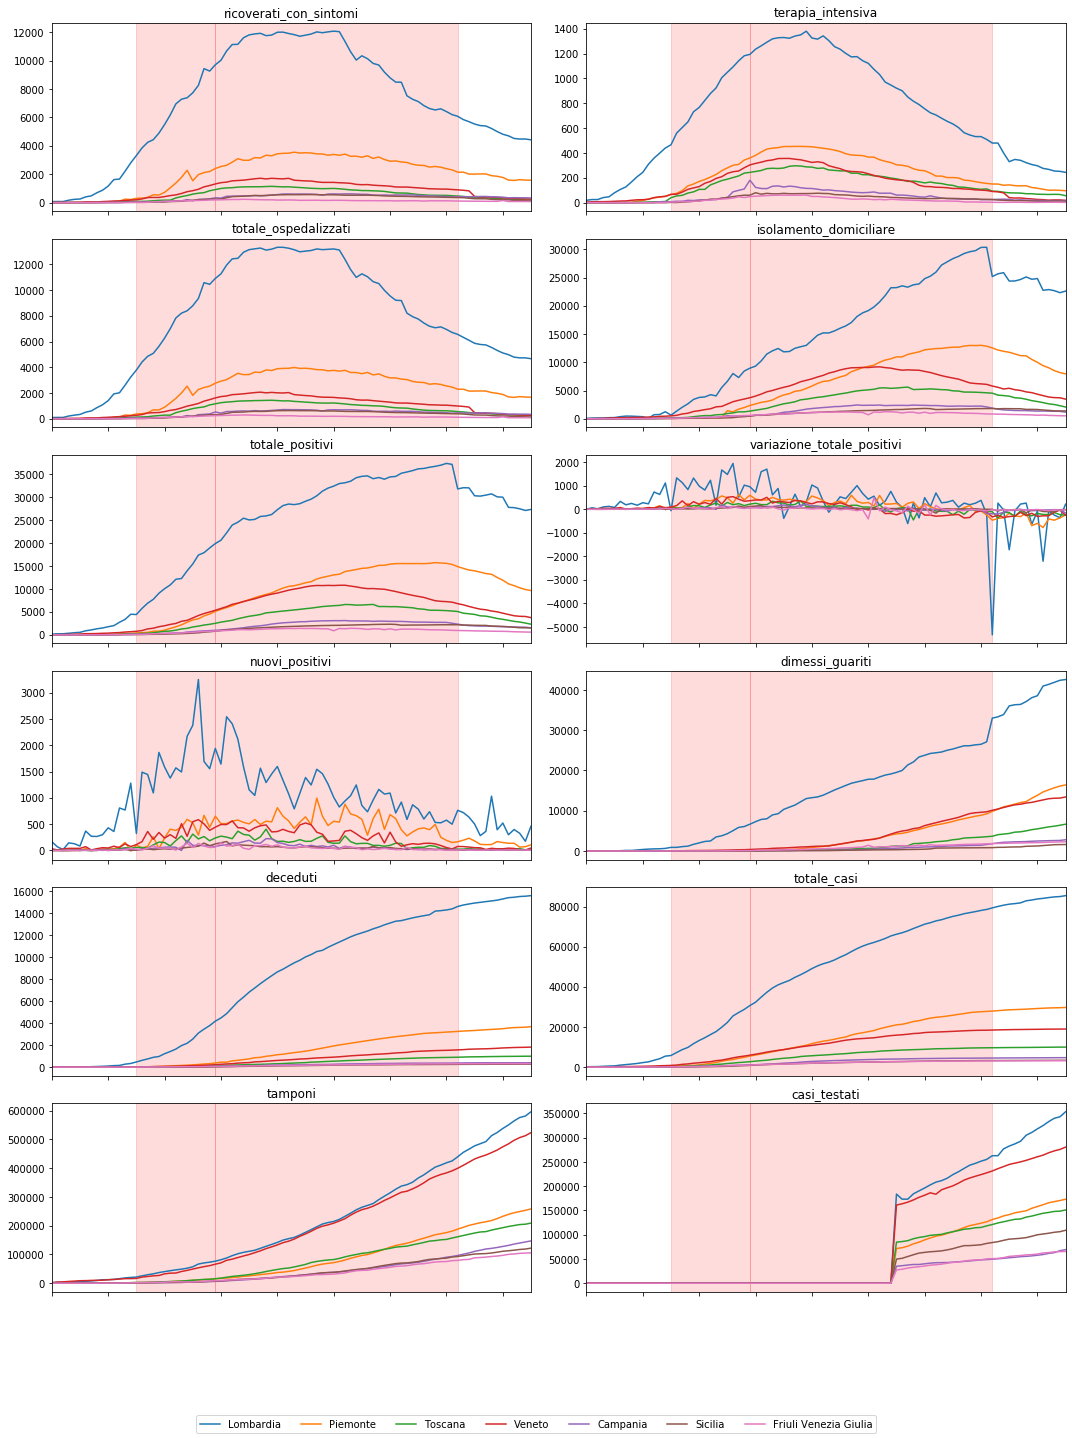

In [35]:
regions_considered = ['Lombardia', 'Piemonte', 'Toscana', 'Veneto', 'Campania', 'Sicilia', 'Friuli Venezia Giulia']
grid_size = (6, 2) # (#regions x #columns's info)
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], sharex=True, figsize=(15,20))

i = 0
r, c = (0,0)
for column_info in regions_data_frame.columns:
    for region in regions_considered:
        regions_data_frame.loc[region][column_info].plot(ax=axes[r,c], kind='line', title=column_info)
        axes[r,c].axvspan(29, 72, color='red', alpha=0.02)
        axes[r,c].axvspan(15, 29, color='red', alpha=0.02)
        axes[r,c].set_xticklabels([])
    
    c = (c+1)%grid_size[1]
    if c == 0:
        r+=1
#a.plot(kind='line', legend=True)
#plt.ylabel("intensive care")
#ax = plt.gca()
#ax.axes.xaxis.set_visible(False)
plt.tight_layout()
fig.subplots_adjust(bottom=0.1)
fig.legend(labels=regions_considered, loc="lower center", ncol=len(regions_considered))

In [ ]:
# CLAU da qui in giù
# showing clean province data
province_data = pd.DataFrame(covid19_provinces_data)
#province.set_index('data', 'denominazione_provincia')
# not showing the "denominazione_provincia"s in updating phase and not useful columns
refined_province_data = province_data[province_data.denominazione_provincia!= "In fase di definizione/aggiornamento"].drop(columns=["long", "lat", "note_it", "note_en", "codice_provincia", "codice_regione", "stato"])
refined_province_data.head()

In [ ]:
# setting as index "data" for province_data
refined_province_data_by_data = refined_province_data.set_index("data")
refined_province_data_by_data.head()

In [ ]:
# setting as index "denominazione_provincia" for province_data
refined_province_data_by_province = refined_province_data.set_index("denominazione_provincia")
refined_province_data_by_province.head()

In [ ]:
# setting as index "data" and "denominazione_provincia"
refined_province_data_by_data_and_province = refined_province_data.set_index(["data", "denominazione_provincia"])
refined_province_data_by_data_and_province.head()


In [ ]:
# Grouping on data in order to see how many cases there are day by day
# (Nota: raggruppare per regione per far vedere quanti casi ci sono ad una certa data è inutile, dato che abbiamo
#   questo dato già nel file delle regioni

total_cases_by_date = refined_province_data_by_data_and_province.groupby(['data']).sum()
total_cases_by_date.head()


In [ ]:
total_cases_by_date.tail()

In [ ]:
# plotting a graph showing day by day the number of total cases in Italy
ax = total_cases_by_date.plot(lw=2, title="Total cases in Italy by date", kind="bar")

ax.set_xlabel("date")

# sampling the dates on the ticks labels (printing a date label every 5 days)
# TODO magari formattare le date in modo che appaiano più leggibili, magari taglianod i minuti e secondi e lasciando
# solo giorno mese anno
xticks = ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 5 != 0:
        xticks[i].set_visible(False)

# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()


In [ ]:
# showing the average number of cases(in each province) day by day (da vedere se tenere oppure no, il grafico viene
#  della stessa forma di questo sopra)
average_number_cases_by_date = refined_province_data_by_data_and_province.groupby(['data']).mean()
average_number_cases_by_date.head()


In [ ]:
# group by "sigla_provincia" and sum all the values. Showing the top 15 provinces with the highest value on
# 'totale_casi'
refined_province_data.groupby(['sigla_provincia']).sum().nlargest(15, 'totale_casi').plot(kind="bar")
plt.title("Top 20 provinces with most cases")

In [36]:
# group by "sigla_provincia" and sum all the values. Showing the top 15 provinces with the highest value on
# 'totale_casi'
refined_province_data.groupby(['sigla_provincia']).sum().nlargest(15, 'totale_casi').plot(kind="bar")
plt.title("Top 20 provinces with most cases")

,data,denominazione_provincia,denominazione_regione,sigla_provincia,totale_casi
0,2020-02-24T18:00:00,Chieti,Abruzzo,CH,0
1,2020-02-24T18:00:00,L'Aquila,Abruzzo,AQ,0
2,2020-02-24T18:00:00,Pescara,Abruzzo,PE,0
3,2020-02-24T18:00:00,Teramo,Abruzzo,TE,0
5,2020-02-24T18:00:00,Matera,Basilicata,MT,0


In [37]:
# setting as index "data" for province_data
refined_province_data_by_data = refined_province_data.set_index("data")
refined_province_data_by_data.head()

,denominazione_provincia,denominazione_regione,sigla_provincia,totale_casi
data,,,,
2020-02-24T18:00:00,Chieti,Abruzzo,CH,0
2020-02-24T18:00:00,L'Aquila,Abruzzo,AQ,0
2020-02-24T18:00:00,Pescara,Abruzzo,PE,0
2020-02-24T18:00:00,Teramo,Abruzzo,TE,0
2020-02-24T18:00:00,Matera,Basilicata,MT,0


In [38]:
# setting as index "denominazione_provincia" for province_data
refined_province_data_by_province = refined_province_data.set_index("denominazione_provincia")
refined_province_data_by_province.head()

,data,denominazione_regione,sigla_provincia,totale_casi
denominazione_provincia,,,,
Chieti,2020-02-24T18:00:00,Abruzzo,CH,0
L'Aquila,2020-02-24T18:00:00,Abruzzo,AQ,0
Pescara,2020-02-24T18:00:00,Abruzzo,PE,0
Teramo,2020-02-24T18:00:00,Abruzzo,TE,0
Matera,2020-02-24T18:00:00,Basilicata,MT,0


In [39]:
# setting as index "data" and "denominazione_provincia"
refined_province_data_by_data_and_province = refined_province_data.set_index(["data", "denominazione_provincia"])
refined_province_data_by_data_and_province.head()


denominazione_regione  \
data                denominazione_provincia                         
2020-02-24T18:00:00 Chieti                                Abruzzo   
                    L'Aquila                              Abruzzo   
                    Pescara                               Abruzzo   
                    Teramo                                Abruzzo   
                    Matera                             Basilicata   

                                            sigla_provincia  totale_casi  
data                denominazione_provincia                               
2020-02-24T18:00:00 Chieti                               CH            0  
                    L'Aquila                             AQ            0  
                    Pescara                              PE            0  
                    Teramo                               TE            0  
                    Matera                               MT            0

In [40]:
# Grouping on data in order to see how many cases there are day by day
# (Nota: raggruppare per regione per far vedere quanti casi ci sono ad una certa data è inutile, dato che abbiamo
#   questo dato già nel file delle regioni

total_cases_by_date = refined_province_data_by_data_and_province.groupby(['data']).sum()
total_cases_by_date.head()


,totale_casi
data,
2020-02-24T18:00:00,0
2020-02-25T18:00:00,312
2020-02-26T18:00:00,370
2020-02-27T18:00:00,625
2020-02-28T18:00:00,826


In [41]:
total_cases_by_date.tail()

,totale_casi
data,
2020-05-15T17:00:00,220641
2020-05-16T17:00:00,221498
2020-05-17T17:00:00,222165
2020-05-18T17:00:00,222613
2020-05-19T17:00:00,223415


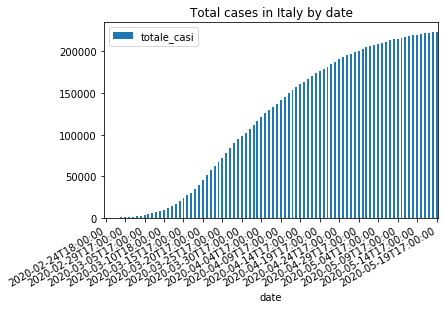

In [42]:
# plotting a graph showing day by day the number of total cases in Italy
ax = total_cases_by_date.plot(lw=2, title="Total cases in Italy by date", kind="bar")

ax.set_xlabel("date")

# sampling the dates on the ticks labels (printing a date label every 5 days)
# TODO magari formattare le date in modo che appaiano più leggibili, magari taglianod i minuti e secondi e lasciando
# solo giorno mese anno
xticks = ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 5 != 0:
        xticks[i].set_visible(False)

# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()


In [43]:
# showing the average number of cases(in each province) day by day (da vedere se tenere oppure no, il grafico viene
#  della stessa forma di questo sopra)
average_number_cases_by_date = refined_province_data_by_data_and_province.groupby(['data']).mean()
average_number_cases_by_date.head()


,totale_casi
data,
2020-02-24T18:00:00,0.000000
2020-02-25T18:00:00,2.915888
2020-02-26T18:00:00,3.457944
2020-02-27T18:00:00,5.841121
2020-02-28T18:00:00,7.719626


Text(0.5, 1.0, 'Top 20 provinces with most cases')

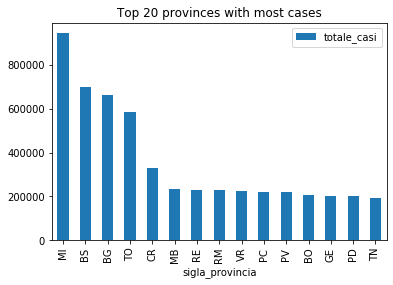

In [44]:
# group by "sigla_provincia" and sum all the values. Showing the top 15 provinces with the highest value on
# 'totale_casi'
refined_province_data.groupby(['sigla_provincia']).sum().nlargest(15, 'totale_casi').plot(kind="bar")
plt.title("Top 20 provinces with most cases")